Tries to estimate the dimension of the search space vs number of unknown entries.

Search space is the space of singular values of matrices. For n x n matrix, it is n-dimensional.

If these entries were independent, then these two should be equal. Then we should expect exact recovery only if no more than n entries are unknown. This definitely is not the case though.

From Candes' paper, https://statweb.stanford.edu/~candes/papers/MatrixCompletion.pdf, if number of sampled entries m obeys:

$$m > C n^{1.2} r \log(n)$$

then most matrices can be recovered with high probability (if r is small). If r is large, the following holds:

$$m > C n^{1.25} r \log(n)$$

If entries were independent, then the maximum number of unknown entries can't be larger than n, i.e. number of sampled entries m should be larger than:

$$m > n^2 - n = n(n - 1)$$

All of this tells that in general, dimension of the search space is much smaller than the number of unknown entries.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from scipy.stats import gaussian_kde
from mpl_toolkits.mplot3d import axes3d

In [2]:
def plot_density(x,y,fig,ax):
    x = np.array(x)
    y = np.array(y)

    # Calculate the point density
    xy = np.vstack([x,y])
    z = gaussian_kde(xy)(xy)

    # Sort the points by density, so that the densest points are plotted last
    idx = z.argsort()
    x, y, z = x[idx], y[idx], z[idx]

    ax.scatter(x, y, c=z, s=50, edgecolor='')
    plt.show()

In [343]:
def get_feasable_point(known_values, mask, n):
    choices = np.random.randn(n, n)
    choices[mask] = 0
    
    point = known_values + choices
    
    return point

In [86]:
rank = 1
n = 100

U = np.random.randn(n, rank)
V = np.random.randn(n, rank)
original = np.dot(U, V.T)

num_unknowns = []
manifold_dimesnsions = []

pca = PCA(n_components = n) # there are only n singular values for n x n matrix

for unknowns in range(1,n*n):
    mask = np.array([0] * unknowns + [1] * (n*n - unknowns))
    mask = np.ma.make_mask(mask)
    
    for trials in range(3):
        np.random.shuffle(mask)
        mask = np.reshape(mask, [n,n])

        known_values = np.copy(original)
        known_values[~mask] = 0

        #noise = sigma * np.random.randn(n, n)
        #known_values = noise + original

        iters = 2 * unknowns

        S = []

        for i in range(iters):
            S.append(np.linalg.svd(get_feasable_point(known_values, mask), compute_uv=False))

        # append the desired solution
        S.append(np.linalg.svd(known_values, compute_uv=False))

        S = np.array(S)

        model = pca.fit(S)
        manifold_dimesnsions.append(np.argmax(np.cumsum(model.explained_variance_ratio_) > 0.9999999))
        num_unknowns.append(unknowns)
    print(unknowns, manifold_dimesnsions[-1])

1 0
2 2
3 3
4 4
5 5
6 6
7 6
8 8
9 9
10 10
11 10
12 12
13 11
14 12
15 15
16 14
17 15
18 18
19 17
20 16
21 19
22 19
23 19
24 21
25 20
26 20
27 22
28 24
29 23
30 24
31 23
32 23
33 28
34 23
35 27
36 29
37 29
38 28
39 30
40 31
41 28
42 28
43 29
44 31
45 34
46 32
47 32
48 33
49 32
50 32
51 33
52 35
53 37
54 38
55 36
56 37
57 38
58 37
59 39
60 38
61 40
62 36
63 37
64 42
65 42
66 41
67 40
68 42
69 40
70 46
71 46
72 44
73 44
74 46
75 46
76 48
77 51
78 50
79 49
80 49
81 52
82 49
83 52
84 50
85 46
86 49
87 50
88 48
89 51
90 50
91 52
92 50
93 51
94 52
95 53
96 52
97 55
98 55
99 58
100 54
101 52
102 57
103 52
104 59
105 56
106 62
107 55
108 60
109 59
110 58
111 54
112 55
113 62
114 59
115 62
116 60
117 56
118 61
119 67
120 59
121 65
122 67
123 64
124 65
125 64
126 66
127 63
128 62
129 67
130 65
131 68
132 66
133 66
134 63
135 65
136 62
137 67
138 71
139 66
140 68
141 69
142 62
143 67
144 63
145 70
146 71
147 71
148 67
149 65
150 66
151 68
152 72
153 70
154 65
155 66
156 68
157 69
158 71
159 72
160 

KeyboardInterrupt: 

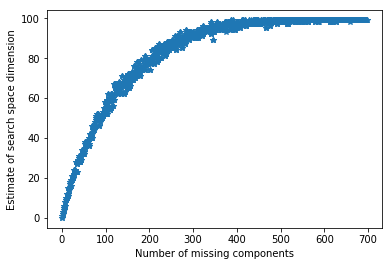

In [89]:
fig, ax = plt.subplots()

ax.set_xlabel("Number of missing components")
ax.set_ylabel("Estimate of search space dimension")

#plot_density(num_unknowns, manifold_dimesnsions,fig,ax)
ax.plot(num_unknowns, manifold_dimesnsions, '*')

The matrix is 100 x 100 and the dimension of the space of singular values is 100. Plot above shows that the subspace of singular values where the matrices live is actually quite small for small number of missing entries and then grows to almost fill in the whole space (largest value of the subspace detected above is 99 -- I actually thing that the more accurate estimate for dimensions would be the numbers abouve +1 added to every one). As long as the subspace of feasible matrices doesn't fill the whole space of singular values, exact recovery should be possible in principle -- above, exact recovery is possible up to about 400 missing components out of 100 * 100 = 10000 components of the matrix (so the matrix can be recovered if up to about 4% of its components are missing).

What this also tells is that it could be possible to solve the problem in a smaller subspace, what could be faster and also could reduce sensitivity to errors in data. Furhtermore, the problem still will be convex. But this only works if the number of missing entries is rather small -- about 100 above. Comparing to $m > C n^{1.2} r \log(n)$, this seems rather small number (I am not sure what C to know for sure)

Let's try to recover the $Cn^{1.2}r\log(n)$ result from this somehow...

In [94]:
rank = 1

max_missing = []

for n in range(1,1000):

    U = np.random.randn(n, rank)
    V = np.random.randn(n, rank)
    original = np.dot(U, V.T)

    pca = PCA(n_components = n) # there are only n singular values for n x n matrix

    for unknowns in range(1,n*n):
        mask = np.array([0] * unknowns + [1] * (n*n - unknowns))
        mask = np.ma.make_mask(mask)

        np.random.shuffle(mask)
        mask = np.reshape(mask, [n,n])

        known_values = np.copy(original)
        known_values[~mask] = 0

        iters = 2 * unknowns

        S = []

        for i in range(iters):
            S.append(np.linalg.svd(get_feasable_point(known_values, mask), compute_uv=False))

        # append the desired solution
        S.append(np.linalg.svd(known_values, compute_uv=False))

        S = np.array(S)

        model = pca.fit(S)
        if np.argmax(np.cumsum(model.explained_variance_ratio_) > 0.9999999)+1 == n:
            break
    max_missing.append(unknowns)
    print(n, unknowns)
        

1 116
2 1
3 2
4 5
5 5
6 9
7 12
8 13
9 16
10 16
11 24
12 27
13 27
14 28
15 37
16 35
17 42
18 50
19 54
20 45
21 54
22 47
23 65
24 75
25 56
26 77
27 81
28 80
29 87
30 85
31 91
32 79
33 93
34 111
35 91
36 118
37 117
38 118
39 118
40 117
41 128
42 114
43 137
44 136
45 140
46 138
47 139
48 162
49 174
50 162
51 172
52 182
53 163
54 188
55 187
56 191
57 202
58 205
59 176
60 213
61 205
62 224
63 227
64 220
65 231
66 227
67 241
68 220
69 235
70 263
71 265
72 261
73 250
74 270
75 263
76 257
77 284
78 288
79 280
80 299
81 290
82 330
83 295
84 311
85 301
86 325
87 350
88 359
89 331
90 333
91 350
92 346
93 331
94 337
95 363
96 330
97 402
98 414
99 384
100 389
101 397
102 380
103 401
104 400
105 359
106 424
107 424
108 432
109 431
110 444
111 445
112 461
113 485
114 466
115 450
116 475
117 478
118 505
119 480
120 515
121 497
122 492
123 529
124 501
125 538
126 526
127 506
128 551
129 564
130 553
131 509
132 579
133 562
134 578
135 589


KeyboardInterrupt: 

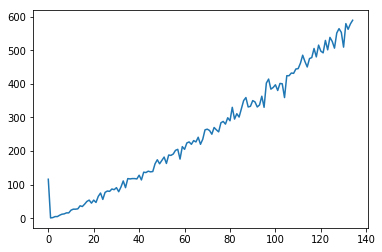

In [95]:
plt.plot(max_missing)

In [98]:
np.size(max_missing)

135

Displaying plot 1


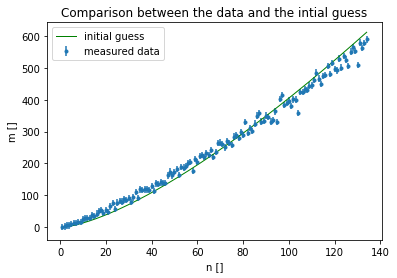


Goodness of fit - chi square measure:
Chi2 = 249.77376589546643, Chi2/dof = 1.892225499208079

Fit parameters:
C = 7.611e-01 +/- 3.515e-02
b = 1.027e+00 +/- 9.982e-03
Displaying plot 2


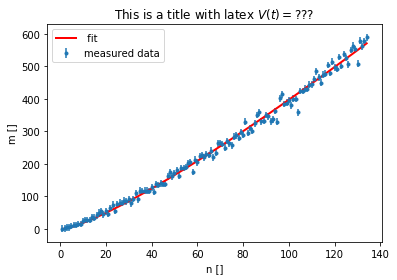


Residual information:
61.9% of data points agree with fit

Displaying plot 3


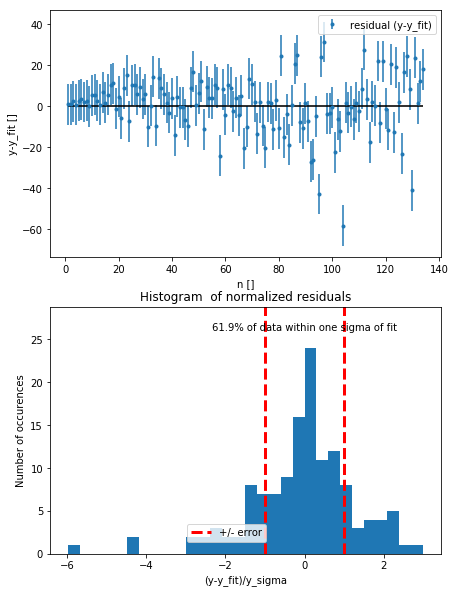

In [123]:
from scipy.optimize import curve_fit

x_name = 'n'
x_units = ''
y_name = 'm'
y_units = '' 
guesses = (0.35,1.2)

def fit_function(x, a, b):
    return a* x**b * np.log(x)

x = np.arange(np.size(max_missing)) 
y = max_missing

x = x[1:]
y = y[1:]

y_sigma = np.ones(np.size(x))
y_sigma=y_sigma*10

x_fitfunc=np.linspace(min(x),max(x),500)
    
#compares the guessed curve to the data for visual reference
y_guess = fit_function(x_fitfunc,*guesses)
plt.errorbar(x,y,yerr=y_sigma,marker='.',linestyle='',label="measured data")
plt.plot(x_fitfunc,y_guess,marker="",linestyle="-",linewidth=1,color="g",
         label="initial guess")
plt.xlabel('{} [{}]'.format(x_name,x_units))
plt.ylabel('{} [{}]'.format(y_name,y_units))
plt.title('Comparison between the data and the intial guess')
plt.legend(loc='best',numpoints=1)
print ('Displaying plot 1')
plt.show()


    
    
# fit the data to fit_function. fit_params is the resultant parameters, fit_cov
# is the covariance matrix between all the parameters. maxfev=10**5 means the
# fitting procedure is iterated at maximum 10^5 times before giving up.
fit_params,fit_cov = curve_fit(fit_function,x,y,sigma=y_sigma,p0=guesses,
                               maxfev=10**5)
                               
###############################################################################
# prints the chi2 
###############################################################################

# function that  calculates the chi square value of a fit
def chi_square (fit_parameters, x, y, sigma):
#
    return np.sum((y-fit_function(x, *fit_parameters))**2/sigma**2)
    
# calculate and print chi square as well as the per degree-of-freedom value
chi2 = chi_square(fit_params,x,y,y_sigma)
dof = len(x) - len(fit_params)
print ("\nGoodness of fit - chi square measure:")
print ("Chi2 = {}, Chi2/dof = {}\n".format(chi2, chi2/dof))

###############################################################################
# prints the fit parameters (with uncertainty)
###############################################################################

# the covariance matrix is rescaled to cancel the inverse scaling that is 
# performed for numerical reasons during execution of curve_fit -- do not 
# change this line!
fit_cov = fit_cov*dof/chi2
# calculate the standard deviation as uncertainty of the fit parameters
fit_params_error = np.sqrt(np.diag(fit_cov))

# read out parameter results
param_names = ['C','b']
print ("Fit parameters:")
for i in range(len(fit_params)):
    print ('{} = {:.3e} +/- {:.3e}'.format(param_names[i],
                                          fit_params[i],
                                          fit_params_error[i]))


# prints out the covariance between all variables. Uncomment this code to see
# the results of this more sophisticated statistical measure.
#print "\nCovariance between fit parameters:"
#for i,fit_covariance in enumerate(fit_cov):
#    for j in xrange(i+1,len(fit_covariance)) :
#        print "{} and {} : {:.3e}".format(param_names[i],
#                                          param_names[j],
#                                          fit_cov[i,j])
                                                                        
###############################################################################
# plots the data and the fit curve
###############################################################################
    
# y_fitfunc is the curve using the parameters calculated from the fit
#x_fit = np.linspace(min(f),max(f),len(f))
y_fitfunc = fit_function(x_fitfunc,*fit_params)
# plots y, and y_fit on the same plot.
# marker='.' : data points are not indicated by markers
# linestyle= '-' : a continuous line is drawn
# linewidth=2 : the line thickness is set to 2
# color='r' : the color of the line is set to red
# label=string : the string is shown in the legend
plt.errorbar(x,y,yerr=y_sigma,marker='.',linestyle='',label="measured data")
plt.plot(x_fitfunc,y_fitfunc,marker="",linestyle="-",linewidth=2,color="r",
         label=" fit")
# add axis labels and title
plt.xlabel('{} [{}]'.format(x_name,x_units))
plt.ylabel('{} [{}]'.format(y_name,y_units))
plt.title(r'This is a title with latex $V(t)=???$')
# set the x and y boundaries of your plot
#plt.xlim(lower_x,upper_x)
#plt.ylim(lower_y,upper_y)
# show a legend. loc='best' places legend where least amount of data is 
# obstructed. 
plt.legend(loc='best',numpoints=1)
print ('Displaying plot 2')
# plt.show() may or may not need to be commented out depending on your python
# editor (spyder) settings.
plt.show()


###############################################################################
# plots residual and histogram of residual. Don't touch this par tof the code
###############################################################################

# residual is the difference between the data and theory
y_fit=fit_function(x,*fit_params)
residual = y-y_fit
#calculate normalized residuals
normresidual=residual/y_sigma
# creates a histogram of the normalized residuals
hist,bins = np.histogram(normresidual,bins=30)

# this complicated code produces a figure with a plot of the residuals as well
# as a histogram of the residuals. You do not need to understand this code.
fig = plt.figure(figsize=(7,10))
ax1 = fig.add_subplot(211)
ax1.errorbar(x,residual,yerr=y_sigma,marker='.',linestyle='',
             label="residual (y-y_fit)")
ax1.hlines(0,np.min(x),np.max(x),lw=2,alpha=0.8)
ax1.set_xlabel('{} [{}]'.format(x_name,x_units))
ax1.set_ylabel('y-y_fit [{}]'.format(y_units))
ax1.legend(loc='best',numpoints=1)
ax2 = fig.add_subplot(212)
ax2.bar(bins[:-1],hist,width=bins[1]-bins[0])

ax2.set_ylim(0,1.2*np.max(hist))
ax2.set_xlabel('(y-y_fit)/y_sigma')
ax2.set_ylabel('Number of occurences')
plt.title('Histogram  of normalized residuals')
#if y_sigma != None:
# within_err is the percentage of data points whose error bars overlap with 
# the fit. If chi2/dof = 1, within_error ~ 66% (one standard deviation)
within_err=100.*np.sum((residual<=y_sigma)&(residual>=-y_sigma))/len(residual)
print ("\nResidual information:")
print ('{:.1f}% of data points agree with fit'.format(within_err))
ax2.vlines(-1.0,0,np.max(hist)*1.3,lw=3,color='r',linestyles='--')
ax2.vlines(+1.0,0,np.max(hist)*1.3,lw=3,color='r',linestyles='--',label='+/- error')
ax2.text(0.0,np.max(hist)*1.1,'{:.1f}% of data within one sigma of fit'.format(within_err),
         horizontalalignment='center',verticalalignment='center')
ax2.legend(loc=(0.35,0.05))

print ('\nDisplaying plot 3')
plt.show()

T-score between the expected exponent and one from the fit

In [119]:
np.abs(1.027 - 1.2)/9.982e-03

17.331196153075542

Note: a value of 1.2 for exponent of x definitely won't work here because it will introduce structure to the residuals

Save data for later use

In [120]:
np.save('dimension_estimations', max_missing)

## Another way

Another, and maybe more direct way of computing dimension of a manifold is to compute the gradient for every coordinate in the domain of the manifold to the range of the manifold. This gives a matrix, whose rank gives the dimension of the manifold.

In [332]:
def comp_grad(m,mask,num_missing, n):
    """ Computes gradient that maximizes the objective function """
    epsilon = 1e-16
    
    # grad:
    # <--- missing entries --->
    #      ^
    #      |
    # singular values
    #      |
    #      v
    
    grad = np.zeros([num_missing,n])

    count = 0
    for i in range(n):
        for j in range(n):
            if not mask[i,j]:
                diff = np.zeros([n,n])
                diff[i,j] = epsilon
                grad[count,:] = (np.linalg.svd(m + diff, compute_uv=False) \
                                 - np.linalg.svd(m - diff, compute_uv=False))/(2*epsilon)
                
                count = count + 1
                
    return grad

In [355]:
def get_dim(k, n):
    """ Computes dimension of the manifold for an n x n matrix with k unknowns """
    rank = 1

    U = np.random.randn(n, rank)
    V = np.random.randn(n, rank)
    original = np.dot(U, V.T)

    starting_point = np.copy(original)
    mask = np.array([0] * k + [1] * (n*n - k))
    mask = np.ma.make_mask(mask)

    np.random.shuffle(mask)
    mask = np.reshape(mask, [n,n])
    
    point = get_feasable_point(starting_point, mask, n)
    
    return np.linalg.matrix_rank(comp_grad(point,mask,k, n), tol=0.1)

In [356]:
n = 10

dim_vs_k = []

for k in range(2,100):
    dim = get_dim(k, n)
    dim_vs_k.append(dim)
    print(k, dim)

2 0
3 1
4 2
5 1
6 1
7 3
8 4
9 6
10 3
11 8
12 6
13 7
14 9
15 9
16 6
17 9
18 8
19 8
20 7
21 10
22 10
23 9
24 10
25 9
26 9
27 10
28 9
29 9
30 9
31 10
32 9
33 10
34 9
35 9
36 9
37 9
38 10
39 10
40 9
41 10
42 10
43 10
44 10
45 10
46 10
47 10
48 10
49 10
50 10
51 10
52 10
53 10
54 10
55 10
56 10
57 8
58 10
59 10
60 10
61 10
62 10
63 9
64 10
65 9
66 10
67 10
68 10
69 10
70 10
71 9
72 10
73 10
74 10
75 10
76 10
77 10
78 10
79 10
80 9
81 10
82 10
83 10
84 10
85 10
86 9
87 10
88 10
89 9
90 10
91 10
92 10
93 10
94 10
95 10
96 10
97 10
98 10
99 9


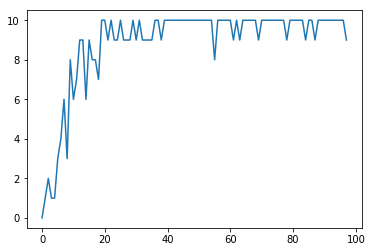

In [357]:
plt.plot(dim_vs_k)

In [358]:
def find_max_dim(n):
    """
        Compute number of unknowns in an n x n matrix that creates a manifold that completely fills in the
        singular value space (i.e get k for which dimension of the manifold is n)
        
        This should correspond to number of unknowns when the matrix just becomes unrecoverable
    """
    
    for k in range(1,n*n):
        dim = get_dim(k, n)
        if dim == n:
            break
    
    return k

In [361]:
dims = []
ns = []

for n in range(2,1000):
    dim = find_max_dim(n)
    dims.append(dim)
    ns.append(n)
    print(n,dim)

2 2
3 7
4 8
5 9
6 10
7 13
8 17
9 15
10 21
11 21
12 17
13 26
14 27
15 28
16 26
17 32
18 38
19 36
20 44
21 41
22 42
23 47
24 47
25 58
26 57
27 59
28 63
29 65
30 58
31 68
32 72
33 57
34 69
35 68
36 62
37 75
38 70
39 60
40 74
41 72
42 75
43 80
44 96
45 86
46 88
47 88
48 97
49 93
50 99
51 96
52 82
53 104
54 98
55 106
56 120
57 113
58 119
59 124
60 117
61 120
62 121
63 119
64 123
65 121
66 125
67 145
68 128
69 118
70 149
71 133
72 123
73 141
74 144
75 158
76 149
77 147
78 177
79 165
80 179
81 161
82 142
83 138
84 170
85 183
86 159
87 159
88 188
89 213
90 182
91 169
92 206
93 209
94 192
95 175
96 217
97 194
98 183
99 219
100 214
101 203
102 198
103 246
104 194
105 211
106 216
107 202
108 236
109 211
110 225
111 231
112 208
113 203
114 211
115 242
116 228
117 227
118 216
119 247
120 223
121 276
122 200
123 244
124 273
125 249
126 229
127 269
128 267
129 250
130 265
131 270
132 269
133 298
134 279
135 289
136 263


KeyboardInterrupt: 

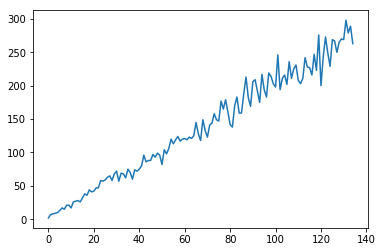

In [362]:
plt.plot(dims)

Seems linear

In [363]:
np.save('dimension_estimations_grad', dims)

Displaying plot 1


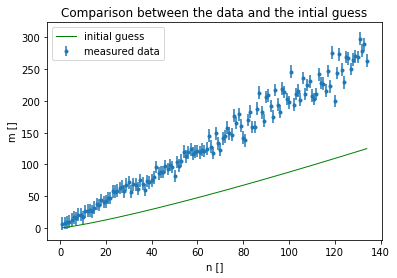


Goodness of fit - chi square measure:
Chi2 = 213.85935159809256, Chi2/dof = 1.6201466030158527

Fit parameters:
C = 2.036e+00 +/- 1.517e-01
b = 1.002e+00 +/- 1.626e-02
Displaying plot 2


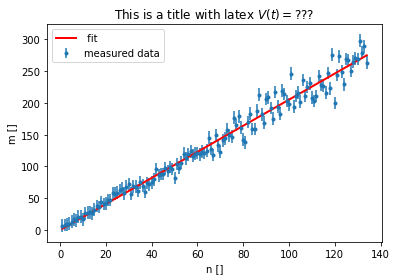


Residual information:
67.9% of data points agree with fit

Displaying plot 3


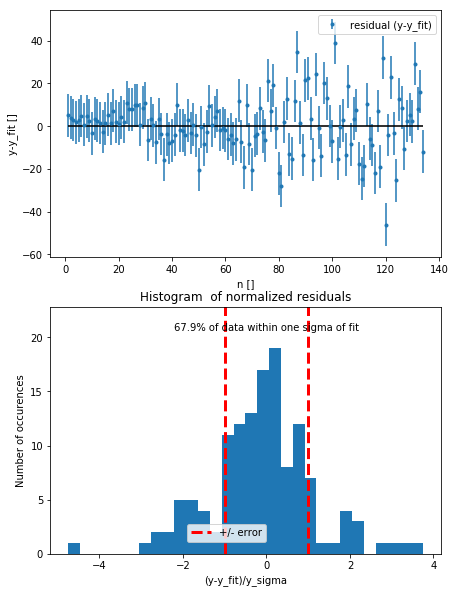

In [364]:
from scipy.optimize import curve_fit

x_name = 'n'
x_units = ''
y_name = 'm'
y_units = '' 
guesses = (0.35,1.2)

def fit_function(x, a, b):
    return a * x**b

x = np.arange(np.size(dims)) 
y = dims

x = x[1:]
y = y[1:]

y_sigma = np.ones(np.size(x))
y_sigma=y_sigma*10

x_fitfunc=np.linspace(min(x),max(x),500)
    
#compares the guessed curve to the data for visual reference
y_guess = fit_function(x_fitfunc,*guesses)
plt.errorbar(x,y,yerr=y_sigma,marker='.',linestyle='',label="measured data")
plt.plot(x_fitfunc,y_guess,marker="",linestyle="-",linewidth=1,color="g",
         label="initial guess")
plt.xlabel('{} [{}]'.format(x_name,x_units))
plt.ylabel('{} [{}]'.format(y_name,y_units))
plt.title('Comparison between the data and the intial guess')
plt.legend(loc='best',numpoints=1)
print ('Displaying plot 1')
plt.show()


    
    
# fit the data to fit_function. fit_params is the resultant parameters, fit_cov
# is the covariance matrix between all the parameters. maxfev=10**5 means the
# fitting procedure is iterated at maximum 10^5 times before giving up.
fit_params,fit_cov = curve_fit(fit_function,x,y,sigma=y_sigma,p0=guesses,
                               maxfev=10**5)
                               
###############################################################################
# prints the chi2 
###############################################################################

# function that  calculates the chi square value of a fit
def chi_square (fit_parameters, x, y, sigma):
#
    return np.sum((y-fit_function(x, *fit_parameters))**2/sigma**2)
    
# calculate and print chi square as well as the per degree-of-freedom value
chi2 = chi_square(fit_params,x,y,y_sigma)
dof = len(x) - len(fit_params)
print ("\nGoodness of fit - chi square measure:")
print ("Chi2 = {}, Chi2/dof = {}\n".format(chi2, chi2/dof))

###############################################################################
# prints the fit parameters (with uncertainty)
###############################################################################

# the covariance matrix is rescaled to cancel the inverse scaling that is 
# performed for numerical reasons during execution of curve_fit -- do not 
# change this line!
fit_cov = fit_cov*dof/chi2
# calculate the standard deviation as uncertainty of the fit parameters
fit_params_error = np.sqrt(np.diag(fit_cov))

# read out parameter results
param_names = ['C','b']
print ("Fit parameters:")
for i in range(len(fit_params)):
    print ('{} = {:.3e} +/- {:.3e}'.format(param_names[i],
                                          fit_params[i],
                                          fit_params_error[i]))


# prints out the covariance between all variables. Uncomment this code to see
# the results of this more sophisticated statistical measure.
#print "\nCovariance between fit parameters:"
#for i,fit_covariance in enumerate(fit_cov):
#    for j in xrange(i+1,len(fit_covariance)) :
#        print "{} and {} : {:.3e}".format(param_names[i],
#                                          param_names[j],
#                                          fit_cov[i,j])
                                                                        
###############################################################################
# plots the data and the fit curve
###############################################################################
    
# y_fitfunc is the curve using the parameters calculated from the fit
#x_fit = np.linspace(min(f),max(f),len(f))
y_fitfunc = fit_function(x_fitfunc,*fit_params)
# plots y, and y_fit on the same plot.
# marker='.' : data points are not indicated by markers
# linestyle= '-' : a continuous line is drawn
# linewidth=2 : the line thickness is set to 2
# color='r' : the color of the line is set to red
# label=string : the string is shown in the legend
plt.errorbar(x,y,yerr=y_sigma,marker='.',linestyle='',label="measured data")
plt.plot(x_fitfunc,y_fitfunc,marker="",linestyle="-",linewidth=2,color="r",
         label=" fit")
# add axis labels and title
plt.xlabel('{} [{}]'.format(x_name,x_units))
plt.ylabel('{} [{}]'.format(y_name,y_units))
plt.title(r'This is a title with latex $V(t)=???$')
# set the x and y boundaries of your plot
#plt.xlim(lower_x,upper_x)
#plt.ylim(lower_y,upper_y)
# show a legend. loc='best' places legend where least amount of data is 
# obstructed. 
plt.legend(loc='best',numpoints=1)
print ('Displaying plot 2')
# plt.show() may or may not need to be commented out depending on your python
# editor (spyder) settings.
plt.show()


###############################################################################
# plots residual and histogram of residual. Don't touch this par tof the code
###############################################################################

# residual is the difference between the data and theory
y_fit=fit_function(x,*fit_params)
residual = y-y_fit
#calculate normalized residuals
normresidual=residual/y_sigma
# creates a histogram of the normalized residuals
hist,bins = np.histogram(normresidual,bins=30)

# this complicated code produces a figure with a plot of the residuals as well
# as a histogram of the residuals. You do not need to understand this code.
fig = plt.figure(figsize=(7,10))
ax1 = fig.add_subplot(211)
ax1.errorbar(x,residual,yerr=y_sigma,marker='.',linestyle='',
             label="residual (y-y_fit)")
ax1.hlines(0,np.min(x),np.max(x),lw=2,alpha=0.8)
ax1.set_xlabel('{} [{}]'.format(x_name,x_units))
ax1.set_ylabel('y-y_fit [{}]'.format(y_units))
ax1.legend(loc='best',numpoints=1)
ax2 = fig.add_subplot(212)
ax2.bar(bins[:-1],hist,width=bins[1]-bins[0])

ax2.set_ylim(0,1.2*np.max(hist))
ax2.set_xlabel('(y-y_fit)/y_sigma')
ax2.set_ylabel('Number of occurences')
plt.title('Histogram  of normalized residuals')
#if y_sigma != None:
# within_err is the percentage of data points whose error bars overlap with 
# the fit. If chi2/dof = 1, within_error ~ 66% (one standard deviation)
within_err=100.*np.sum((residual<=y_sigma)&(residual>=-y_sigma))/len(residual)
print ("\nResidual information:")
print ('{:.1f}% of data points agree with fit'.format(within_err))
ax2.vlines(-1.0,0,np.max(hist)*1.3,lw=3,color='r',linestyles='--')
ax2.vlines(+1.0,0,np.max(hist)*1.3,lw=3,color='r',linestyles='--',label='+/- error')
ax2.text(0.0,np.max(hist)*1.1,'{:.1f}% of data within one sigma of fit'.format(within_err),
         horizontalalignment='center',verticalalignment='center')
ax2.legend(loc=(0.35,0.05))

print ('\nDisplaying plot 3')
plt.show()